In [13]:
import sys, os
cwd = os.getcwd()
addedpath=cwd+"/periodic_kdtree/"
print("Adding path: ", addedpath)
sys.path.append(addedpath)
print("New path including required packages: ", sys.path)


import numpy as np
import periodic_kdtree
from periodic_kdtree import PeriodicCKDTree
import scipy.spatial
import time
from mpl_toolkits.mplot3d import Axes3D
import pickle
import gzip
import networkx as netx
import getopt

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
# %matplotlib inline
mpl.rcParams['image.cmap'] = 'autumn'


def read_input_parameters(param_filename='Parameters.in'):
    input_parameters = np.genfromtxt(param_filename,delimiter='=',comments='#',dtype=str)
    input_parameters[:,0]
    input_parameters[:,1]

    # input_parameter_names, input_parameter_values = np.split( input_parameters, [1], axis=1)
    input_parameter_names = input_parameters[:,0]
    input_parameter_values = input_parameters[:,1]
    parameters = dict({})
    for name, value in zip(input_parameter_names, input_parameter_values):
    #     print(name)
        #assume parameter is numeric
        try:
            parameters.setdefault(name, (eval(value)))
        except Exception as e:
            #assume paraemter is string
            try:
                parameters.setdefault(name, value)
            except Exception as e:
                print(e,'\n',name)

    parameters.setdefault('set_leafsize', int(parameters['set_leafsize_factor'] * parameters['num_neighbors']) )
    input_parameter_names=  parameters.keys()
    return parameters

def parameter_values(parameters, *args):
#     print(args)
    return args


def compute_correction(x,r,ineighbors,pts,radii_scaled):
    print("COMPUTE CORRECTION")

    # if(len(ineighbors)>1):
    #     1;
    # else:
    #     print(len(ineighbors))

    xn = pts[ineighbors]
    # print("xn")
    # print(xn)
    rn = radii_scaled[ineighbors]
    # print("rn")
    # print(rn)
    # print(xn.shape,x.shape)
    dxn = (xn - x[None,:]) 
    dn = np.linalg.norm(x[None,:]-xn,2,axis=1)
    # print("dn, dxn")
    # print(dn, dxn.shape)
    # print(rn.shape,r.shape)

    correct = (r+ rn)
    # print("correct")
    # print(correct)
    # correct = correct[:,None] - dxn * dn[:,None]
    # correct = correct / dn[:,None]

    correct = correct[:,None] - dxn / dn[:,None]
    correct = correct * dn[:,None]
    for c in correct:
        x += c
    # correct = np.sum(correct, axis=0)
    print("correct")
    print(x)

    return x
# xn = pts[ineighbors]
# rn = radii_scaled[ineighbors]
# dn = np.linalg.norm(x[:,None]-xn,2,axis=0)
# correct = (r[:,None] + rn) - (xn - x[:,None]) * 2 * dn
# correct = np.sum(correct, axis=0)
# return correct

def overlap_correction(i, x, r, pts,radii_scaled, kdt, registered, unregistered, dmax, search_radius_factor_of_max_diameter=2, pnorm=2, eps=1e-2):       
    search_radius = search_radius_factor_of_max_diameter * dmax
    ineighbors = kdt.query_ball_point(x, search_radius, pnorm, eps)
    ineighbors = np.array(ineighbors) 
    
    if(ineighbors.shape[0] < 2 ):
        reinit_flag=0
        # return x,0

    print(ineighbors.shape[0])
    if(ineighbors.shape[0]>2):
        print(pts.shape)
        dist_collide = np.linalg.norm(x[None,:] - pts[ineighbors], pnorm, axis=1)
        my_collision_length = radii_scaled[ineighbors] + r
        icollide = (dist_collide < my_collision_length)
        icollidesum = (icollide).sum()

    else:
        dist_collide = np.linalg.norm(x[:]-pts[ineighbors], pnorm)
        icollidesum=0
    try:
        if( icollidesum < 1 ):
            reinit_flag = 0
            # return x, reinit_flag
        else:
            print("CORRECT")
            icollide = np.where(icollide)
            print(icollide)
            print(ineighbors)

            icollneigh = icollide
            # icollneigh = np.intersect_1d(icollide,ineighbors)
            print(icollneigh)

            # correct = compute_correction(x,r,icollide,pts,radii_scaled)
            x = compute_correction(x,r,icollide,pts,radii_scaled)
            print("CORRECTION COMPUTED")
            reinit_flag=0

            # x = x + correct
            # x,reinit_flag = overlap_correction(i, x, r, pts,radii_scaled, kdt, registered, unregistered, dmax, search_radius_factor_of_max_diameter, pnorm, eps)
        
    except Exception:
        print(' \n \n Exception During Collision Check: Re-initialize with new random seed \n \n ')
    return x, reinit_flag
# print('x ', x)
# print('icollidesum ', icollidesum)
# print('r ', r)
# print('registered ', len(registered))
# print('unregistered ', len(unregistered))
# reinit_flag = 1
# return x, reinit_flag

# return correct,0


def compute_all_overlap(pts, neighbors, nsamples, collision_length_factor):
    dist_collide = np.linalg.norm(pts[neighbors[:,0:1]]-pts[neighbors[:,1:]], axis=2)
    icollide = dist_collide < collision_length_factor
    icollide = np.where(icollide)
    pcoll, ncoll = icollide
    pcoll = np.unique(pcoll)
    ncoll = np.unique(ncoll)

    num_pcoll = np.unique(icollide[0]).shape[0] 
    num_ncoll = np.unique(icollide[1]).shape[0]
    (num_pcoll / nsamples), (num_ncoll / nsamples)
    return icollide, pcoll, ncoll, num_pcoll, num_ncoll


def where_boundary_intersect(parameters, pts,radii_scaled):
    xmin,xmax=parameters['xmin'],parameters['xmax']
    ymin,ymax=parameters['ymin'],parameters['ymax']
    zmin,zmax=parameters['zmin'],parameters['zmax']
    
    cond = (pts**2).sum(axis=1)-radii_scaled**2 > xmax**2
    cond = cond + ((pts**2).sum(axis=1)-radii_scaled**2 < xmin**2)
    cond = cond + ((pts**2).sum(axis=1)+radii_scaled**2 > ymax**2)
    cond = cond +((pts**2).sum(axis=1)-radii_scaled**2 < ymin**2)
    cond = cond + ((pts**2).sum(axis=1)+radii_scaled**2 > zmax**2)
    cond = cond +((pts**2).sum(axis=1)-radii_scaled**2 < zmin**2)
    return cond, cond.sum()


def get_reflected_pts(pts,idx_points, boundary, boundary_indices, boundary_radii, radii_scaled,xmin,xmax):
    sz0 = pts.shape[0]
    ptsr = pts**2 - radii_scaled[:,None]**2 
    #indices of spheres crossing lower boundary
    ip1 = np.any(ptsr < xmin,axis=1)
    #image spheres
    pts1 = np.mod(ptsr[ip1],xmax-xmin)

    # boundary = np.vstack((boundary, pts1.copy()))
    # boundary_indices = np.vstack((boundary_indices, ip1.copy()));
    # boundary_radii = np.vstack((boundary_radii, radii_scaled[ip1]))

    boundary.extend(pts1.tolist())
    boundary_indices.extend(ip1.tolist())
    boundary_radii.extend(radii_scaled[ip1].tolist())

    #tack on image spheres
    pts = np.vstack((pts,pts1.copy()))
    #tack on image indices
    if(len(ip1)>0):
        print(idx_points.shape)
        idx_points = np.hstack((idx_points,ip1[np.where(ip1)[0]]))
    #append image sphere radii
    radii_scaled = np.concatenate((radii_scaled,radii_scaled[ip1]))

    #DO IT AGAIN FOR THE UPPER BOUNDARIES
    ptsr = pts**2 + radii_scaled[:,None]**2
    ip1 = np.any(ptsr > xmax,axis=1)
    pts1 = np.mod(ptsr[ip1],xmax-xmin)

    # boundary = np.vstack((boundary, pts1.copy()))
    # boundary_indices = np.vstack((boundary_indices, ip1.copy()));
    # boundary_radii = np.vstack((boundary_radii, radii_scaled[ip1]))

    boundary.extend(pts1.tolist())
    boundary_indices.extend(ip1.tolist())
    boundary_radii.extend(radii_scaled[ip1].tolist())


    pts = np.vstack((pts,pts1.copy()))
    if(len(ip1)>0):
        print(idx_points.shape)
        idx_points = np.hstack((idx_points,ip1[np.where(ip1)[0]]))
    radii_scaled = np.concatenate((radii_scaled,radii_scaled[ip1]))
    sz = np.unique( pts ,axis=0).shape[0]
    print(sz,sz0)
    flag = 1 if( sz==sz0) else 0
        
    return pts, radii_scaled, idx_points, boundary, boundary_indices, boundary_radii, flag


def Run_Correlated_Sphere_Packing(input_parameters_filename="Parameters.in", seed_increment = 0, seed=None,periodic_geometry=None,nsamples=None,target_porosity=None):
    parameters = read_input_parameters(input_parameters_filename)
    reinit_flag=0

    '''debugging, ignore this'''
    print(','.join(np.array([name for name in parameters.keys()])))

    try:
        if(seed is not None):
            parameters['seed'] = seed
    except Exception as e:
        print('no seed specified')

    try:
        if(periodic_geometry is not None):
            parameters['periodic_geometry'] = periodic_geometry
    except Exception as e:
        print('no periodicv geometry specified')

    try:
        if(nsamples is not None):
            parameters['nsamples'] = nsamples
    except Exception as e:
        print('no nsampels specified')

    try:
        if(target_porosity is not None):
            parameters['target_porosity'] = target_porosity
    except Exception as e:
        print('no porosity specified')



    '''increment in case of reinitialization'''
    print(" seed_increment ", seed_increment, " type ", type(seed_increment))
    parameters['seed']+=seed_increment

    '''use input parameters'''
    periodic_geometry,ndimensions,xmin,xmax,ymin,ymax,zmin,zmax,seed,radius_mu,radius_sig2,Cmu,Csig,filename,radii_dist,nsamples,target_porosity,nbins,num_neighbors,set_leafsize_factor,kdt_eps,pnorm,search_radius_factor_of_max_diameter,find_all_neighbors,percentilemin,percentilemax,show_hist,set_dt,blfac,damping,tstep,tprint,tstepmax,force_abstol,fmin,force_absmax_factor,force_reltol,max_overlap_factor,set_leafsize_factor \
    =parameter_values(parameters, *parameters.values())
#     print(xmin,xmax)
    RandomState = np.random.RandomState(seed)

    '''form uniform hexahedral mesh'''
    ncells = nsamples
    xx=np.linspace(xmin,xmax,ncells+1)
    dcell = np.diff(xx)[0]
    domain_volume = (xmax-xmin) * (ymax-ymin) * (zmax-zmin)

    periodic_bounds = np.array([xmax,ymax,zmax])[:ndimensions]



#lognormal
# probability distr. fcn.
# cumulative distr. fcn.
# inverse cdf 
# q05 = np.exp( )
#get rmin, rmin+rrange=:rmax given quantiles
#with quantiles, get truncated CDF
# given mean and variance, have median

    #PART I
    '''sample radii'''
    # #sample radii 
    # while target_porosity < v0:
    # v0 = (radii**3 * 4*np.pi/(3 * (xmax-xmin)**3))
    # v0 = v0/v0.sum()
    if(radii_dist=='lognormal'):
        # V prior error, fix: mean of lognormal is mean of associated normal distribution

        #lognormal:
        # mean: exp(mu+sig2/2) 
        #median exp(mu) 
        #mode exp(mu - sig2) 
        #variance = mean^2 (-1+E^\[Sigma]^2)}
        #quantile q = E^(\[Mu] - Sqrt[2] \[Sigma]^2 InverseErfc[2 q])
        #Quantiles 
        # q05 = E^(\[Mu] - Sqrt[2]*E^(\[Mu] - Sqrt[2]*\[Sigma]^2*InverseErfc[1/10])*\[Sigma])
        # q95 = E^(\[Mu] - Sqrt[2]*E^(\[Mu] + Sqrt[2]*\[Sigma]^2*InverseErfc[1/10])*\[Sigma])} - -E^(\[Mu] - Sqrt[2]*E^(\[Mu] - Sqrt[2]*\[Sigma]^2*InverseErfc[1/10])*\[Sigma])

        # lognormal_sig2 = np.log( radius_sig2 / radius_mu**2 + 1 )
        # lognormal_mu = np.log( radius_mu ) - lognormal_sig2 / 2

        # Z = RandomState.lognormal( lognormal_mu , lognormal_sig2 ,nsamples)
        Z = RandomState.lognormal( np.log(radius_mu) , radius_sig2 ,nsamples)

        radii = np.exp(Z)

    if(show_hist==True):
        plt.hist(radii,nbins)
        plt.savefig('hist.png')

    pmin = np.percentile(radii,percentilemin),
    pmax = np.percentile(radii,percentilemax)
    radii = radii[radii<pmax]
    radii = radii[radii>pmin]
    nsamplesclip = nsamples - radii.shape[0]
    nsamples = radii.shape[0]# - nsamplesclip
    radii = np.sort(radii)


    
    
    print('1,99 percentiles ', pmin,pmax)
    print('max, min, mean', radii.max(),radii.min(),radii.mean())



    '''rescale radii to obtain desired porosity'''
    rscale = ( (  np.sum(4*np.pi*(1/3.) * radii**3) ) / ( domain_volume * (1-target_porosity) ) )**(1/3)
    radii_scaled = radii/rscale
    radius_mu_scaled = radius_mu / rscale
    radius_sig2_scaled = radius_sig2 / rscale**2
    rmax = ( radii_scaled ).max()
    dmax = 2*rmax
    delta = dcell - 2*rmax
    search_radius = 2*dmax#+delta

    # print("IINTERIOR " , iinterior)


    #TBD
    '''sample isotropic gaussian correlation'''
    Cnorm = RandomState.multivariate_normal(Cmu,Csig,nsamples)#,[nsamples,ndimensions])

    '''sample points uniformly in space '''
    pts = RandomState.uniform(0,1,[nsamples,ndimensions])
    pts[:,0] = (pts[:,0] ) * (xmax-xmin) + xmin
    pts[:,1] = (pts[:,1] ) * (ymax-ymin) + ymin
    pts[:,2] = (pts[:,2] ) * (zmax-zmin) + zmin


    '''sort radii and points '''
    radii_scaled = radii_scaled[::-1]
    pts = pts[::-1,:]
    
    '''get nearest neighbor distances'''
    t0 = time.time()

    if(periodic_geometry==True):
        kdt = PeriodicCKDTree(periodic_bounds, pts)
    else:
        kdt = scipy.spatial.KDTree(pts) #,leafsize=set_leafsize_factor * num_neighbors )
    if(find_all_neighbors==True):
        dist,neighbors = kdt.query(pts, k=num_neighbors, eps=kdt_eps, p = pnorm)

        print("NNE time " , time.time()-t0)

        '''sort by func(distances) eg sum'''
        distsum = (dist[:,1:].sum(axis=1))
        distmean = (dist[:,1:].mean(axis=1))
        distmedian = np.median(dist[:,1:],axis=1)
        distmin = (dist[:,1:].min(axis=1))
        distmax = (dist[:,1:].max(axis=1))

        isort_pts = np.argsort(distmedian)
        isort_radii = np.argsort(isort_pts)

        sorted_radii = radii[isort_radii].copy()
        edges = from_neighbors_to_edges(neighbors)[0]

    '''overlap'''
    max_overlap = radius_mu_scaled * max_overlap_factor
    #find neighbors I interesect (in 3/9/27 cells), use centers and radii to move away by dx if ||dx||<overlap_max


    '''BC, EQ separation, pore throat size, collision distances, PD'''
    boundary_layer = [blfac, xmax *(1- blfac)]
    # IINT
    print("BOUINDARY LAYER" , boundary_layer)
    iboundary = np.any(((pts<boundary_layer[0]).astype(int)+(pts>boundary_layer[1]).astype(int)) , axis=1)
    iinterior = np.all((pts>boundary_layer[0]).astype(int) * (pts<boundary_layer[1]).astype(int),axis=1)
    # print("IBOUNDARY " , iboundary)
    # print("IINTERIOR " , iinterior)
    print('\n \n \n ' , " NUMBER OF BOUNDARY SPHERES ", iboundary.sum(), " TOTAL CONSIDERED ", iboundary.shape, '\n \n \n ' , "NUMBER OF INTERIOR SPHERES", iinterior.sum(), " TOTAL CONSIDERED ",  iinterior.shape, '\n \n \n ')
    # ,iboundary.sum()




    ''' Detect Collisions and Translate Spheres '''
    registered = []
    unregistered = [i for i in range(nsamples)]
    boundary = []
    t_list = []
    tlast = time.time()
    for i,(x,r) in enumerate(zip( pts , radii_scaled)):
        if(i%1000==0):
            print(i,x,r, time.time())
        if(i==0):
            registered.append(i)
            pts[i] = x
            radii_scaled[i] = r
        else:
            x,reinit_flag = overlap_correction(i, x, r, pts, radii_scaled, kdt, registered, unregistered, dmax, search_radius_factor_of_max_diameter, pnorm=2, eps=kdt_eps)
            if(reinit_flag==1):
                if(periodic_geometry==1):
                    break;
            elif(reinit_flag==0):                    
                registered.append(i)
                pts[i] = x
                radii_scaled[i] = r
        unregistered.remove(i)

        t_list.append(time.time() - tlast)
        tlast = time.time()

    # if(reinit_flag==1):
    #     print(" \n Reinitializing Simulation \n")
    #     return Run_Correlated_Sphere_Packing(seed_increment+1)
    # else:
    #     print("\n No collisions found, continuing.. \n")
    t_list = np.array(t_list)

    registered = np.array(registered)




    print("STORE BOUNDARY SPHERE DATA")
    indices_boundary = np.where(iboundary)
    print("STORE INTERIOR SPHERE DATA")
    indices_interior = np.where(iinterior)

    interior_points = pts[indices_interior]
    boundary_points = pts[indices_boundary]

    print("SET POINT IDs (to keep track of boundary image spheres)")
    idx_points = np.arange(0,len(registered))



    boundary, boundary_indices, boundary_radii = [], [], [] #np.array([]), np.array([]), np.array([])
    if(periodic_geometry==1):
        print("COPY BOUNDARY POINTS TO IMAGE SPHERES ACROSS PERIODIC BOUNDARIES")
        print("NUM POINTS BEFORE BOUNDARY IMAGE COPY" , pts.shape)
        flag=0
        # while flag==0:
        # pts, radii_scaled,idx_points, flag = get_reflected_pts(pts,idx_points, radii_scaled,xmin,xmax)


        pts, radii_scaled, idx_points, boundary, boundary_indices, boundary_radii, flag = get_reflected_pts(pts,idx_points, boundary, boundary_indices, boundary_radii, radii_scaled,xmin,xmax)
        print(radii_scaled.shape)
        nsamples = radii_scaled.shape[0]
        assert(radii_scaled.shape[0] == pts.shape[0])
        print("NUM POINTS AFTER " , pts.shape)

    # pts = pts[registered]
    # radii_scaled = radii_scaled[registered]
    
    # print(np.all((pts[0]<xmax , pts[1]<ymax , pts[2]<zmax , pts[0]>xmin , pts[1]>ymin , pts[2]>zmin) , axis=2))
    # idbounds = np.where( np.all(pts[0]<xmax , pts[1]<ymax , pts[2]<zmax , pts[0]>xmin , pts[1]>ymin , pts[2]>zmin))[0]
    # print(idbounds)
    # print(idx_points.shape, pts.shape, radii_scaled.shape)

    # seed=parameters['seed']
    # nsamples = parameters['nsamples']
    # ndimensions = parameters['ndimensions']
    # print('seed', seed)
    save_filename = 'packing'
    #save packing output
    stacked_data = np.vstack((idx_points.astype(int), pts[:,0], pts[:,1], pts[:,2], radii_scaled[:])).T
    np.savetxt(save_filename + ".txt", stacked_data, header="ID x y z r", fmt='%i,%E,%E,%E,%E')




    pvolumes = radii_scaled**3 * 4 * np.pi / 3 if ndimensions==3 else radii_scaled**2 * np.pi 
    porosity = 1 - (domain_volume - pvolumes.sum()) / domain_volume

    print("\n domain size ", " [xmin,xmax] ", xmin,xmax, " [ymin,ymax] ", ymin,ymax, " [zmin,zmax] ", zmin,zmax, " volume " , domain_volume)
    print('particle volumes: sum, mean, median, min, max', pvolumes.sum(), pvolumes.mean(), np.median(pvolumes) , pvolumes.min(), pvolumes.max())
    print("\n \n \n porosity ", porosity)
    print("\n number of spheres ", registered.shape)
    print("\n number of registered spheres ", registered.shape)
    print("\n number of unregistered spheres ", registered.shape )
    print("\n sphere distribution parameters ", radius_mu, radius_sig2)
    print("\n mean coordination number ", )
    print("\n \n \n ")
    return parameters, radii_scaled, registered, unregistered, pts, pvolumes, idx_points, boundary, boundary_indices, boundary_radii






Adding path:  /home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/python/periodic_kdtree/
New path including required packages:  ['', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/home/chaztikov/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/chaztikov/.ipython', '/home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/python/periodic_kdtree/', '/home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/python', '/home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/python/periodic_kdtree/', '/home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/python/periodic_kdtree/']


In [1]:
# import sys, os
# cwd = os.getcwd()
# addedpath=cwd+"/periodic_kdtree/"
# print("Adding path: ", addedpath)
# sys.path.append(addedpath)
# print("New path including required packages: ", sys.path)


# import numpy as np
# import periodic_kdtree
# from periodic_kdtree import PeriodicCKDTree
# import scipy.spatial
# import time
# from mpl_toolkits.mplot3d import Axes3D
# import pickle
# import gzip
# import networkx as netx
# import getopt

# import matplotlib.pyplot as plt
# import matplotlib as mpl
# plt.style.use('ggplot')
# # %matplotlib inline
# mpl.rcParams['image.cmap'] = 'autumn'

import os,sys
cwd=os.getcwd()
sys.path.append(cwd)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import run_test_packing
from run_test_packing import *
seed=0
xmax,xmin=1,0
ymax,ymin=2,0
zmax,zmin=4,0
ndimensions=3
radii_dist='lognormal'
radius_mu=1
radius_sig2=0.25
nsamples=1000
percentilemin,percentilemax=5,95

target_porosity=0.4



def compute_correction(x,r,ineighbors,pts,radii_scaled):
    print("COMPUTE CORRECTION")
    xn = pts
    rn = radii_scaled

    dxn = (xn - x[None,:]) 
    dn = np.linalg.norm(x[None,:]-xn,2,axis=1)
    correct = (r+ rn)
    correct = correct[:,None] - dxn / dn[:,None]
    correct = correct * dn[:,None]
    for c in correct:
        x += c
    return x

def overlap_correction(i, x, r, pts, radii_scaled, registered, pnorm=2):
#     pts = allpts[registered]
#     radii_scaled=allradii_scaled[registered]
#     search_radius = search_radius_factor_of_max_diameter * dmax    

    print(pts.shape)
    dist_collide = np.linalg.norm(x[None,:] - pts, pnorm, axis=1)
    my_collision_length = radii_scaled + r
    icollide = (dist_collide < my_collision_length)
    icollidesum = (icollide).sum()
        
    if( icollidesum < 1 ):
        reinit_flag = 0

    else:
        icollide = np.where(icollide)
        x = compute_correction(x,r,icollide,pts,radii_scaled)
        reinit_flag=0

    return x, reinit_flag

'''
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
'''

coord_min,coord_max,coord_minmax=np.min((xmin,ymin,zmin)), np.max((xmax,ymax,zmax)),np.min((xmax,ymax,zmax))
RandomState = np.random.RandomState(0)
print(radius_mu)
lognormal_sig2 = np.log( radius_sig2 / radius_mu**2 + 1 )
lognormal_mu = np.log( radius_mu ) - lognormal_sig2 / 2
Z = RandomState.lognormal( lognormal_mu, lognormal_sig2 ,nsamples)
Z.mean(),np.std(Z)
# RandomState.lognormal?
# nsamples=int(1e5)

# kdt = scipy.spatial.KDTree(pts) #,leafsize=set_leafsize_factor * num_neighbors )
# x,reinit_flag = overlap_correction(i, x, r, pts, radii_scaled, kdt, registered, unregistered, dmax, search_radius_factor_of_max_diameter, pnorm=2, eps=kdt_eps)

    
approx_samples_per_dim = int((nsamples/10)**(1/3))
bbox_rescale_factor = 2*Z.max() * approx_samples_per_dim
xmax *= bbox_rescale_factor
ymax *= bbox_rescale_factor
zmax *= bbox_rescale_factor

''' Detect Collisions and Translate Spheres '''
registered = []
unregistered = [i for i in range(nsamples)]
boundary = []
t_list = []
tlast = time.time()
for i,r in enumerate(Z):
#     pt = RandomState.uniform(0,1)
    pt = RandomState.uniform(0,1,[ndimensions])
    
    pt[0] = (pt[0] ) * (xmax-xmin) + xmin
    pt[1] = (pt[1] ) * (ymax-ymin) + ymin
    pt[2] = (pt[2] ) * (zmax-zmin) + zmin
    x = pt.copy()
    if(i%1000==0):
        print(i,x,r, time.time())
    if(i==0):
        registered.append(i)
        pts = np.array([x.tolist()])
        radii_scaled = np.array([r])
    else:
        x,reinit_flag = overlap_correction(i, x, r, pts, radii_scaled,registered)
        if(reinit_flag==1):
            if(periodic_geometry==1):
                break;
        elif(reinit_flag==0):                    
            registered.append(i)
#             pts[i] = x
            pts = np.vstack((pts,pt))
            radii_scaled = np.hstack((radii_scaled,r))
            Z[i] = r
    unregistered.remove(i)

    t_list.append(time.time() - tlast)
    tlast = time.time()
    
registered=np.array(registered)
domain_volume=xmax*ymax*zmax
save_filename = 'packing'
#save packing output
idx_points = np.arange(0,len(registered))

stacked_data = np.vstack((idx_points.astype(int), pts[:,0], pts[:,1], pts[:,2], radii_scaled[:])).T
np.savetxt(save_filename + ".txt", stacked_data, header="ID x y z r", fmt='%i,%E,%E,%E,%E')




pvolumes = radii_scaled**3 * 4 * np.pi / 3 if ndimensions==3 else radii_scaled**2 * np.pi 
porosity = 1 - (domain_volume - pvolumes.sum()) / domain_volume

print("\n domain size ", " [xmin,xmax] ", xmin,xmax, " [ymin,ymax] ", ymin,ymax, " [zmin,zmax] ", zmin,zmax, " volume " , domain_volume)
print('particle volumes: sum, mean, median, min, max', pvolumes.sum(), pvolumes.mean(), np.median(pvolumes) , pvolumes.min(), pvolumes.max())
print("\n \n \n porosity ", porosity)
print("\n number of spheres ", registered.shape)
print("\n number of registered spheres ", registered.shape)
print("\n number of unregistered spheres ", registered.shape )
print("\n sphere distribution parameters ", radius_mu, radius_sig2)
print("\n mean coordination number ", )
print("\n \n \n ")

'''
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
'''

import numpy as np

idx,x,y,z,r = np.loadtxt("packing.txt",delimiter=",",skiprows=1,unpack=True)

# Check Porosity
volume = 0.
for i in range(0,len(idx)):
	volume = volume + 4./3.*np.pi*r[i]*r[i]*r[i]
print(1.-volume)


# Check Distribution Parameters
print(np.mean(r))
print(np.std(r))

#Check Overlap
count = 0 
for i in range(0,len(idx)):
    add_to_count=0;
    for j in range(i+1,len(idx)):
        distance = np.sqrt( (x[i]-x[j])*(x[i]-x[j]) + (y[i]-y[j])*(y[i]-y[j]) + (z[i]-z[j])*(z[i]-z[j]) )
        if (distance < (r[i]+r[j])):
            add_to_count=1
    count  = count + add_to_count; 
    
print("Total Number of Overlaps ", count-1)= np.loadtxt("packing.txt",delimiter=",",skiprows=1,unpack=True)

# Check Porosity
volume = 0.
for i in range(0,len(idx)):
	volume = volume + 4./3.*np.pi*r[i]*r[i]*r[i]
print(1.-volume)


# Check Distribution Parameters
print(np.mean(r))
print(np.std(r))

#Check Overlap
count = 0 
for i in range(0,len(idx)):
    add_to_count=0;
    for j in range(i+1,len(idx)):
        distance = np.sqrt( (x[i]-x[j])*(x[i]-x[j]) + (y[i]-y[j])*(y[i]-y[j]) + (z[i]-z[j])*(z[i]-z[j]) )
        if (distance < (r[i]+r[j])):
            add_to_count=1
    count  = count + add_to_count; 
    
print("Total Number of Overlaps ", count-1)

Adding path:  /home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/python/periodic_kdtree/
New path including required packages:  ['', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/home/chaztikov/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/chaztikov/.ipython', '/home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/python', '/home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/python/periodic_kdtree/']


1
0 [10.8859207  18.55666813 46.7846063 ] 1.3258650701387222 1541023620.327564
(1, 3)
(2, 3)
(3, 3)
(4, 3)
(5, 3)
(6, 3)
(7, 3)
(8, 3)
(9, 3)
(10, 3)
(11, 3)
(12, 3)
(13, 3)
(14, 3)
(15, 3)
(16, 3)
(17, 3)
(18, 3)
(19, 3)
(20, 3)
(21, 3)
(22, 3)
(23, 3)
(24, 3)
(25, 3)
(26, 3)
(27, 3)
(28, 3)
(29, 3)
(30, 3)
(31, 3)
(32, 3)
(33, 3)
(34, 3)
(35, 3)
(36, 3)
(37, 3)
(38, 3)
(39, 3)
(40, 3)
(41, 3)
(42, 3)
(43, 3)
COMPUTE CORRECTION
(44, 3)
(45, 3)
(46, 3)
(47, 3)
(48, 3)
(49, 3)
(50, 3)
(51, 3)
(52, 3)
(53, 3)
(54, 3)
(55, 3)
(56, 3)
(57, 3)
(58, 3)
(59, 3)
(60, 3)
(61, 3)
(62, 3)
(63, 3)
(64, 3)
(65, 3)
(66, 3)
(67, 3)
(68, 3)
(69, 3)
(70, 3)
(71, 3)
(72, 3)
(73, 3)
(74, 3)
(75, 3)
(76, 3)
(77, 3)
(78, 3)
(79, 3)
(80, 3)
(81, 3)
COMPUTE CORRECTION
(82, 3)
(83, 3)
(84, 3)
(85, 3)
(86, 3)
(87, 3)
(88, 3)
(89, 3)
(90, 3)
(91, 3)
(92, 3)
(93, 3)
(94, 3)
(95, 3)
(96, 3)
COMPUTE CORRECTION
(97, 3)
(98, 3)
(99, 3)
COMPUTE CORRECTION
(100, 3)
(101, 3)
(102, 3)
(103, 3)
(104, 3)
(105, 3)
(106, 3)

(745, 3)
COMPUTE CORRECTION
(746, 3)
COMPUTE CORRECTION
(747, 3)
COMPUTE CORRECTION
(748, 3)
COMPUTE CORRECTION
(749, 3)
COMPUTE CORRECTION
(750, 3)
COMPUTE CORRECTION
(751, 3)
COMPUTE CORRECTION
(752, 3)
(753, 3)
(754, 3)
COMPUTE CORRECTION
(755, 3)
COMPUTE CORRECTION
(756, 3)
(757, 3)
(758, 3)
COMPUTE CORRECTION
(759, 3)
(760, 3)
COMPUTE CORRECTION
(761, 3)
(762, 3)
(763, 3)
COMPUTE CORRECTION
(764, 3)
COMPUTE CORRECTION
(765, 3)
COMPUTE CORRECTION
(766, 3)
(767, 3)
COMPUTE CORRECTION
(768, 3)
COMPUTE CORRECTION
(769, 3)
COMPUTE CORRECTION
(770, 3)
COMPUTE CORRECTION
(771, 3)
(772, 3)
(773, 3)
COMPUTE CORRECTION
(774, 3)
COMPUTE CORRECTION
(775, 3)
(776, 3)
COMPUTE CORRECTION
(777, 3)
COMPUTE CORRECTION
(778, 3)
(779, 3)
(780, 3)
COMPUTE CORRECTION
(781, 3)
COMPUTE CORRECTION
(782, 3)
COMPUTE CORRECTION
(783, 3)
(784, 3)
COMPUTE CORRECTION
(785, 3)
COMPUTE CORRECTION
(786, 3)
COMPUTE CORRECTION
(787, 3)
COMPUTE CORRECTION
(788, 3)
COMPUTE CORRECTION
(789, 3)
COMPUTE CORRECTION
(790, 

In [129]:
pts.shape

(2, 3)

In [99]:
# xmin,xmax = 
# Z.max()*2



1


In [16]:
RandomState = np.random.RandomState(seed)

# '''form uniform hexahedral mesh'''
# ncells = nsamples
# xx=np.linspace(xmin,xmax,ncells+1)
# dcell = np.diff(xx)[0]
domain_volume = (xmax-xmin) * (ymax-ymin) * (zmax-zmin)

periodic_bounds = np.array([xmax,ymax,zmax])[:ndimensions]



#lognormal
# probability distr. fcn.
# cumulative distr. fcn.
# inverse cdf 
# q05 = np.exp( )
#get rmin, rmin+rrange=:rmax given quantiles
#with quantiles, get truncated CDF
# given mean and variance, have median

#PART I
'''sample radii'''
# #sample radii 
# while target_porosity < v0:
# v0 = (radii**3 * 4*np.pi/(3 * (xmax-xmin)**3))
# v0 = v0/v0.sum()
if(radii_dist=='lognormal'):
    # V prior error, fix: mean of lognormal is mean of associated normal distribution

    #lognormal:
    # mean: exp(mu+sig2/2) 
    #median exp(mu) 
    #mode exp(mu - sig2) 
    #variance = mean^2 (-1+E^\[Sigma]^2)}
    #quantile q = E^(\[Mu] - Sqrt[2] \[Sigma]^2 InverseErfc[2 q])
    #Quantiles 
    # q05 = E^(\[Mu] - Sqrt[2]*E^(\[Mu] - Sqrt[2]*\[Sigma]^2*InverseErfc[1/10])*\[Sigma])
    # q95 = E^(\[Mu] - Sqrt[2]*E^(\[Mu] + Sqrt[2]*\[Sigma]^2*InverseErfc[1/10])*\[Sigma])} - -E^(\[Mu] - Sqrt[2]*E^(\[Mu] - Sqrt[2]*\[Sigma]^2*InverseErfc[1/10])*\[Sigma])

    lognormal_sig2 = np.log( radius_sig2 / radius_mu**2 + 1 )
    lognormal_mu = np.log( radius_mu ) - lognormal_sig2 / 2

    # Z = RandomState.lognormal( np.log(radius_mu) , radius_sig2 ,nsamples)
    Z = RandomState.lognormal( lognormal_mu , lognormal_sig2 ,nsamples)
    radii = np.exp(Z)

# if(show_hist==True):
#     plt.hist(radii,nbins)
#     plt.savefig('hist.png')

pmin = np.percentile(radii,percentilemin),
pmax = np.percentile(radii,percentilemax)
radii = radii[radii<pmax]
radii = radii[radii>pmin]
nsamplesclip = nsamples - radii.shape[0]
nsamples = radii.shape[0]# - nsamplesclip
radii = np.sort(radii)




print('1,99 percentiles ', pmin,pmax)
print('max, min, mean', radii.max(),radii.min(),radii.mean())


'''rescale radii to obtain desired porosity'''
rscale = ( (  np.sum(4*np.pi*(1/3.) * radii**3) ) / ( domain_volume * (1-target_porosity) ) )**(1/3)
radii_scaled = radii/rscale
radius_mu_scaled = radius_mu / rscale
radius_sig2_scaled = radius_sig2 / rscale**2
rmax = ( radii_scaled ).max()
dmax = 2*rmax
# delta = dcell - 2*rmax
search_radius = 2*dmax#+delta

print('max, min, mean', radii_scaled.max(),radii_scaled.min(),radii_scaled.mean())

1,99 percentiles  (2.462525941319799,) 2.876287831945722
max, min, mean 2.876286653026397 2.4625270848248704 2.654679888579408
max, min, mean 0.027216008303137855 0.023300931260372696 0.02511912010359949


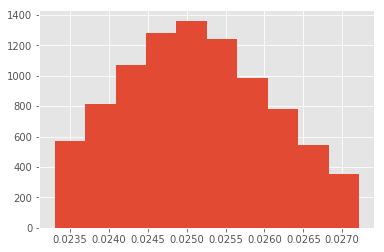

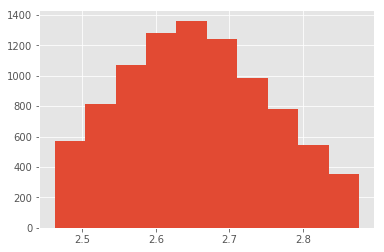

<module 'scipy' from '/home/chaztikov/.local/lib/python3.6/site-packages/scipy/__init__.py'>

In [19]:
plt.hist(radii_scaled,10)
plt.show()

plt.hist(radii,10)
plt.show()

import scipy
scipy.

In [42]:
sphere_volume = 4 * np.pi * radii**3 / 3 
solid_volume = sphere_volume.sum()
# solid_volume / domain_volume
solid_volume
sphere_volume

array([ 62.70373312,  63.35113662,  64.04370005,  64.33731221,
        65.79333763,  65.95246576,  66.43556145,  66.57445979,
        67.42994607,  67.63330288,  68.29187052,  68.94697014,
        69.05857333,  69.13115365,  69.29205645,  69.45073479,
        69.84188199,  70.526995  ,  71.08725054,  71.20867211,
        71.58542383,  72.13823805,  72.8242476 ,  72.8359472 ,
        73.56727847,  73.94188581,  74.09179235,  74.34771753,
        74.38099039,  74.50265694,  74.88440205,  74.98193713,
        75.93524131,  76.01669154,  76.21025269,  76.28861076,
        76.59804065,  77.12327789,  77.95169268,  78.77973247,
        78.84955129,  78.89722091,  79.01432221,  79.64221492,
        79.72590581,  79.89875421,  80.02420904,  80.04035369,
        80.28367255,  81.74777124,  81.87346792,  82.11866228,
        82.65137384,  82.7565703 ,  82.91644857,  82.94283675,
        83.04268187,  83.25766344,  83.44656061,  83.67743286,
        83.71265497,  86.05457284,  87.01949353,  87.43

In [53]:
np.loadtxt("test_packing.txt",delimiter=",",skiprows=1,unpack=True)[4]

array([5.212936e-01, 1.164577e-01, 5.286762e-06, 7.163665e-24,
       4.709212e-29, 3.783721e-32, 1.247231e-33, 1.279572e-34,
       3.947925e-35, 8.235627e-37, 5.046516e-37, 1.307510e-37,
       1.291739e-39, 1.179838e-39, 4.210662e-40, 3.331357e-40,
       6.894119e-41, 1.224514e-41, 8.628754e-42, 5.314217e-42,
       7.197930e-43, 4.867260e-44, 1.133107e-44, 3.565416e-45,
       3.166813e-45, 1.215466e-45, 4.162230e-46, 3.034248e-46,
       1.385203e-46, 1.043896e-46, 8.268197e-47, 6.739883e-47,
       5.019259e-47, 1.337570e-47, 9.297410e-48, 8.757396e-48,
       8.239193e-48, 8.210617e-48, 7.713182e-48, 5.954531e-48,
       4.515303e-48, 3.007078e-48, 2.961771e-48, 2.623039e-48,
       2.606888e-48, 2.605014e-48, 1.759531e-48, 1.308340e-48,
       9.711902e-49, 5.856314e-49, 4.530168e-49, 4.107834e-49,
       3.938094e-49, 3.275083e-49, 2.875640e-49, 2.375583e-49,
       2.192624e-49, 2.127873e-49, 1.657060e-49, 1.629798e-49,
       1.482704e-49, 1.462858e-49, 1.434629e-49, 1.3939

-3619.207043655888
0.9072281975
0.2027947606646958
Total Number of Overlaps  440


In [74]:
r

array([0.06772415, 0.06770995, 0.06761011, 0.06706067, 0.06682915,
       0.06666225, 0.06657197, 0.06650714, 0.06647203, 0.06634749,
       0.06633062, 0.06628267, 0.06609991, 0.06609598, 0.06605028,
       0.06603961, 0.06596485, 0.06587618, 0.06585726, 0.06583049,
       0.06571216, 0.06552786, 0.06541254, 0.06531093, 0.06529992,
       0.06520642, 0.06509059, 0.06505377, 0.06495629, 0.06491872,
       0.06488668, 0.06485774, 0.0648145 , 0.06459418, 0.06452416,
       0.06451216, 0.06449979, 0.06449908, 0.06448623, 0.06443122,
       0.0643689 , 0.06426975, 0.06426585, 0.06423411, 0.06423247,
       0.06423228, 0.0641221 , 0.0640301 , 0.0639282 , 0.06372723,
       0.06360729, 0.06355749, 0.06353522, 0.0634316 , 0.06335139,
       0.06322035, 0.06315975, 0.06313608, 0.06291275, 0.06289597,
       0.06279439, 0.06277902, 0.06275636, 0.06272196, 0.06268151,
       0.06266386, 0.06264389, 0.06257727, 0.06242703, 0.06242143,
       0.06239174, 0.06237644, 0.06234163, 0.06226283, 0.06225